<a href="https://colab.research.google.com/github/delrio-jaemee/CSST106-CS4B-DELRIO/blob/main/4B_DEL_RIO_MP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Harris Corner Detection

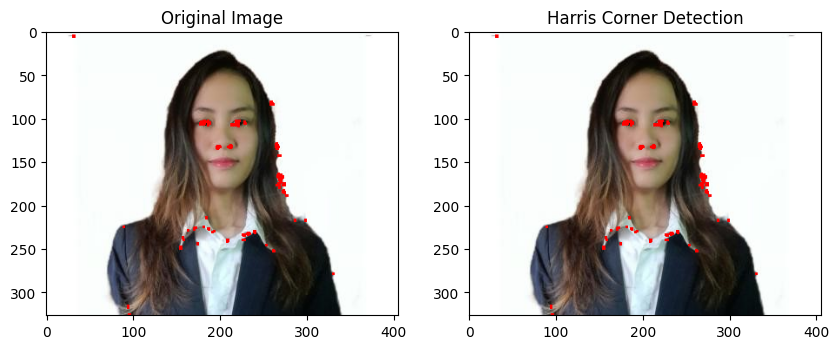

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris_corner(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Harris corner detection
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)

    # Dilate to mark the corners
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value, it may vary depending on the image
    img[dst > 0.01 * dst.max()] = [0, 0, 255]  # Mark corners in red

    # Display the original and the corner detected image
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(122), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Harris Corner Detection')
    plt.show()

# Display results
harris_corner('/content/jae (1).jpg')

HOG Feature Extraction

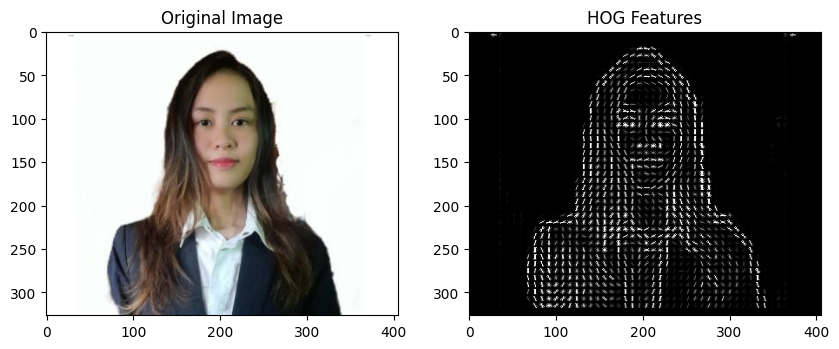

In [ ]:
from skimage.feature import hog
from skimage import exposure

def hog_feature_matching(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply HOG (Histogram of Oriented Gradients) to extract features
    hog_features, hog_image = hog(
        gray_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )

    # Enhance HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display original image and HOG features side-by-side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title('HOG Features')

    plt.show()

# Display results
hog_feature_matching('/content/jae (1).jpg')

ORB Feature Extraction and Matching

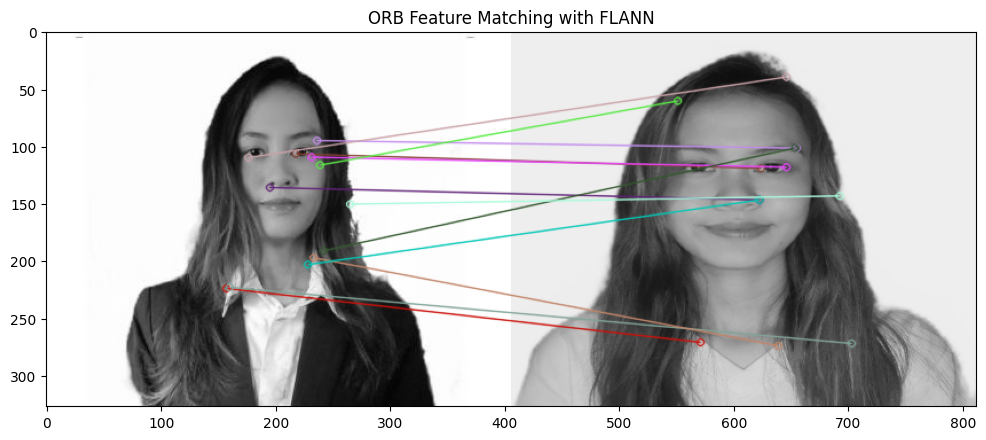

In [ ]:
def orb_feature_matching(image_path1, image_path2):
    # Load the images in grayscale
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        print("Error: One or both images not found.")
        return

    # Resize img2 to match the size of img1 if they are not the same size
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Initiate ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # FLANN parameters for binary descriptors
    index_params = dict(algorithm=6,  # FLANN_INDEX_LSH
                        table_number=6,  # 12 for better precision
                        key_size=12,     # 20 for better precision
                        multi_probe_level=1)  # Higher values increase search speed but reduce accuracy
    search_params = dict(checks=50)  # Higher values increase matching quality but slow down search

    # Create FLANN based matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test as per Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw the good matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the matching keypoints
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches, cmap='gray')
    plt.title('ORB Feature Matching with FLANN')
    plt.show()

# Disply results
orb_feature_matching('/content/jae (1).jpg', '/content/jae 2.jpg')

Feature Matching using Brute Force Matcher

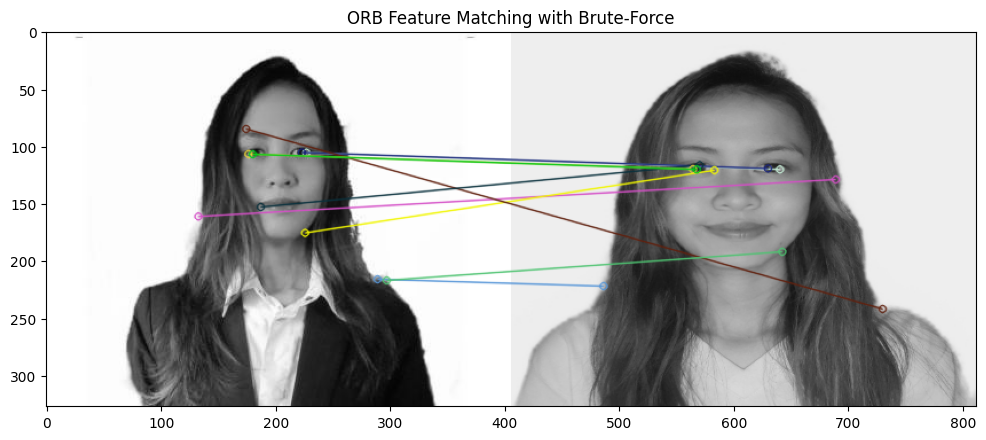

In [ ]:
def brute_force_feature_matching(image_path1, image_path2):
    # Load the images in grayscale
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        print("Error: One or both images not found.")
        return

    # Resize img2 to match the size of img1 if they are not the same size
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Initiate ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Create BFMatcher object with Hamming distance and crossCheck enabled
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort matches based on their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw the best matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the matching keypoints
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches, cmap='gray')
    plt.title('ORB Feature Matching with Brute-Force')
    plt.show()

# Display results
brute_force_feature_matching('/content/jae (1).jpg', '/content/jae 2.jpg')

Image Segmentation using Watershed Algorithm

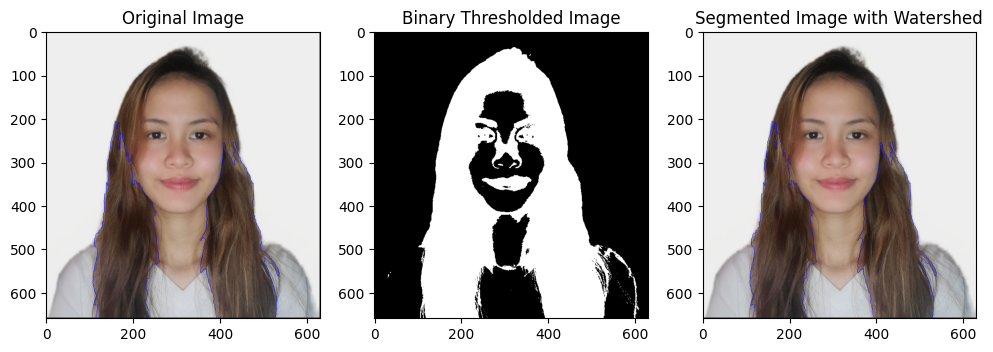

In [ ]:
def watershed_segmentation(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold to get a binary image
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal using morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)

    # Add one to all markers to distinguish sure background
    markers = markers + 1

    # Mark the unknown region with zero
    markers[unknown == 255] = 0

    # Apply watershed algorithm
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark boundaries with red

    # Display the original and segmented images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title("Binary Thresholded Image")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Image with Watershed")

    plt.show()

# Display results
watershed_segmentation('/content/jae 2.jpg')